In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import pickle
import numpy as np

# import Normalize
from matplotlib.colors import Normalize

/Users/thomas/.pyenv/versions/3.9.12/envs/gds/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/18/lkk4lh9d5hb1bmvlwb1kcsth0000gn/T/ipykernel_47624/30821597.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sha

# To do (10/5-2023):

- [ ] Color code which part are bike lanes or not. 
- [ ] Look at the top 100 road-parts if they are bikelanes or not. 


In [2]:
bike_data = gpd.read_file("../data/data_all_gpd_v4.shp")

bike_data.head()

,st_st_id,st_st_name,en_st_id,en_st_name,minutes,id,total_dist,waytypes_d,waytypes_s,geometry
0,408,Tøyen skole,448,Oslo Plaza,7,5391,1502.2,0 3 7;3 13 2;13 20 3;20 50 2;50 82 3;82 91 7;,v:3.0 d:805.9 a:53.65;v:2.0 d:638.3 a:42.49;v:...,"LINESTRING (10.77395 59.91491, 10.77397 59.914..."
1,408,Tøyen skole,448,Oslo Plaza,8,6044,1502.2,0 3 7;3 13 2;13 20 3;20 50 2;50 82 3;82 91 7;,v:3.0 d:805.9 a:53.65;v:2.0 d:638.3 a:42.49;v:...,"LINESTRING (10.77395 59.91491, 10.77397 59.914..."
2,408,Tøyen skole,448,Oslo Plaza,5,31205,1502.2,0 3 7;3 13 2;13 20 3;20 50 2;50 82 3;82 91 7;,v:3.0 d:805.9 a:53.65;v:2.0 d:638.3 a:42.49;v:...,"LINESTRING (10.77395 59.91491, 10.77397 59.914..."
3,397,Storo Storsenter,421,Alexander Kiellands Plass,9,6045,2701.3,0 2 7;2 86 2;86 94 7;94 111 6;111 112 7;112 11...,v:2.0 d:1435.3 a:53.14;v:3.0 d:805.4 a:29.82;v...,"LINESTRING (10.77378 59.94668, 10.77369 59.946..."
4,397,Storo Storsenter,421,Alexander Kiellands Plass,10,7493,2701.3,0 2 7;2 86 2;86 94 7;94 111 6;111 112 7;112 11...,v:2.0 d:1435.3 a:53.14;v:3.0 d:805.4 a:29.82;v...,"LINESTRING (10.77378 59.94668, 10.77369 59.946..."


## Plotting routes as heatmap

To be able to plot routes, we need to check how many types different paths in the city have been used.

In [3]:
type(bike_data.iloc[0].geometry)

shapely.geometry.linestring.LineString

First we have to split all lines into segments. And count how many of each segment in the data in order to plot a nice heatmap. 

In [4]:
str(LineString([(10.786247, 59.904461), (10.786262, 59.904486)]))

'LINESTRING (10.786247 59.904461, 10.786262 59.904486)'

### Counting segments

In [5]:
from tqdm import tqdm

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))


# Check if there is a segments_counts.pickle file in the data folder.
# If there is, load it. If not, create it.
try:
    with open("../data/segments_counts.pickle", "rb") as f:
        segments_counts = pickle.load(f)
        print("Loaded segments_counts from pickle file.")

except FileNotFoundError:

    print("No pickle file found. Creating segments_counts.\n")

    segments_counts = {}
    c = 0

    def segments(curve):
        return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

    with tqdm(total=len(bike_data)) as pbar:
        for i in range(len(bike_data)):

            # Update progress bar
            pbar.update(1)

            # Waytypes for all segments in the line 
            # ([:-1] because last entry is an empty string, so we remove it)
            waytypes = [i.split(" ") for i in bike_data['waytypes_d'].iloc[i].split(';')][:-1]

            # Getting the linestring from geometry.
            line = bike_data.iloc[i].geometry

            # Splitting it into segments
            line_segments = segments(line)

            # For each segment in the line, add the segment to the dict and add count.
            for idx, segment in enumerate(line_segments):

                # Check if it is in the dict, if not add it.
                if segment not in segments_counts:

                    # Getting the waytype for the specific segment
                    for wt in waytypes:
                        if int(wt[0]) <= idx and int(wt[1]) > idx:
                            waytype = wt[2]

                    segments_counts[segment] = [1, waytype]

                # If it is in the dict, add 1 to the count.
                else:
                    segments_counts[segment][0] += 1

    # We are saving the counts dict in a pickle file.
    with open("../data/segments_counts.pickle", "wb") as f:
        pickle.dump(segments_counts, f)


Loaded segments_counts from pickle file.


In [6]:
# Lets check if it worked.
segments_counts

{<LINESTRING (10.774 59.915, 10.774 59.915)>: [952, '7'],
 <LINESTRING (10.774 59.915, 10.774 59.915)>: [952, '7'],
 <LINESTRING (10.774 59.915, 10.774 59.915)>: [537, '7'],
 <LINESTRING (10.774 59.915, 10.774 59.915)>: [509, '2'],
 <LINESTRING (10.774 59.915, 10.774 59.915)>: [509, '2'],
 <LINESTRING (10.774 59.915, 10.774 59.915)>: [509, '2'],
 <LINESTRING (10.774 59.915, 10.773 59.915)>: [509, '2'],
 <LINESTRING (10.773 59.915, 10.773 59.915)>: [509, '2'],
 <LINESTRING (10.773 59.915, 10.773 59.915)>: [509, '2'],
 <LINESTRING (10.773 59.915, 10.773 59.915)>: [509, '2'],
 <LINESTRING (10.773 59.915, 10.773 59.915)>: [509, '2'],
 <LINESTRING (10.773 59.915, 10.773 59.915)>: [489, '2'],
 <LINESTRING (10.773 59.915, 10.772 59.916)>: [489, '2'],
 <LINESTRING (10.772 59.916, 10.772 59.915)>: [439, '3'],
 <LINESTRING (10.772 59.915, 10.772 59.915)>: [439, '3'],
 <LINESTRING (10.772 59.915, 10.77 59.915)>: [439, '3'],
 <LINESTRING (10.77 59.915, 10.77 59.915)>: [439, '3'],
 <LINESTRING (10.

In [7]:
# Creating a geodataframe with the segments as geometry and the counts as a column.
segments_gdf = gpd.GeoDataFrame.from_dict(segments_counts, orient='index', columns=['count', 'waytype'])
segments_gdf.reset_index(inplace=True)
segments_gdf.rename(columns={'index': 'geometry'}, inplace=True)
segments_gdf.set_geometry(col='geometry', inplace=True)
segments_gdf.set_crs(epsg=4326, inplace=True)

,geometry,count,waytype
0,"LINESTRING (10.77395 59.91491, 10.77397 59.91491)",952,7
1,"LINESTRING (10.77397 59.91491, 10.77410 59.91489)",952,7
2,"LINESTRING (10.77410 59.91489, 10.77407 59.91485)",537,7
3,"LINESTRING (10.77407 59.91485, 10.77398 59.91486)",509,2
4,"LINESTRING (10.77398 59.91486, 10.77371 59.91489)",509,2
...,...,...,...
34505,"LINESTRING (10.72961 59.93757, 10.72980 59.93767)",2,7
34506,"LINESTRING (10.72980 59.93767, 10.72990 59.93777)",2,7
34507,"LINESTRING (10.72990 59.93777, 10.72998 59.93784)",2,7
34508,"LINESTRING (10.72998 59.93784, 10.73007 59.93786)",2,7


In [8]:
# adding a normalized count column.
segments_gdf['count_norm'] = segments_gdf['count'] / segments_gdf['count'].max()

### Creating the heatmap with ranges

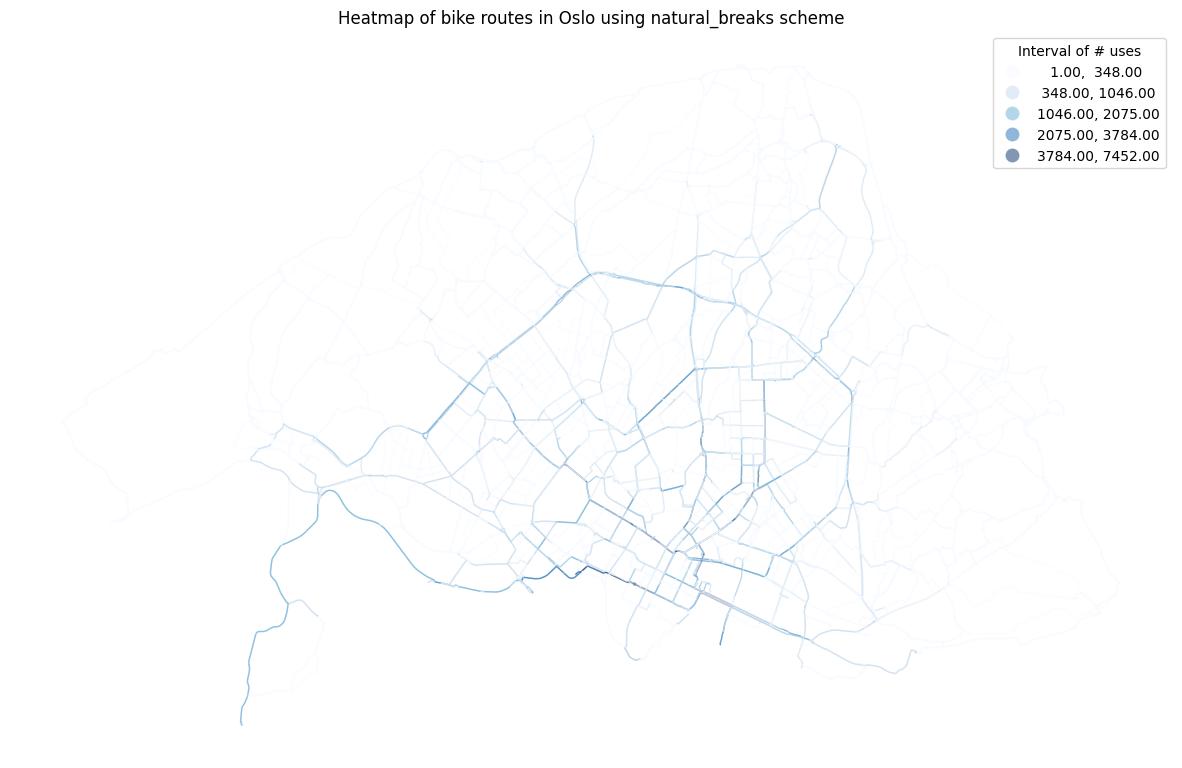

In [9]:
import matplotlib.pyplot as plt

# for scheme in ['quantiles','equal_interval', 'natural_breaks']:
for scheme in ['natural_breaks']:
    # Create heatmap using density_kwds
    ax = segments_gdf.plot(column='count', cmap='Blues', linewidth=1, alpha=0.5, figsize=(15,15),
                scheme=scheme, legend=True, legend_kwds={'title': 'Interval of # uses'}) # 'OrRd'
    ax.set_title(f'Heatmap of bike routes in Oslo using {scheme} scheme')
    
    # remove all axis spines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # remove all axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # set the background to black
    # ax.set_facecolor('black')

    plt.show()

## With colorbar

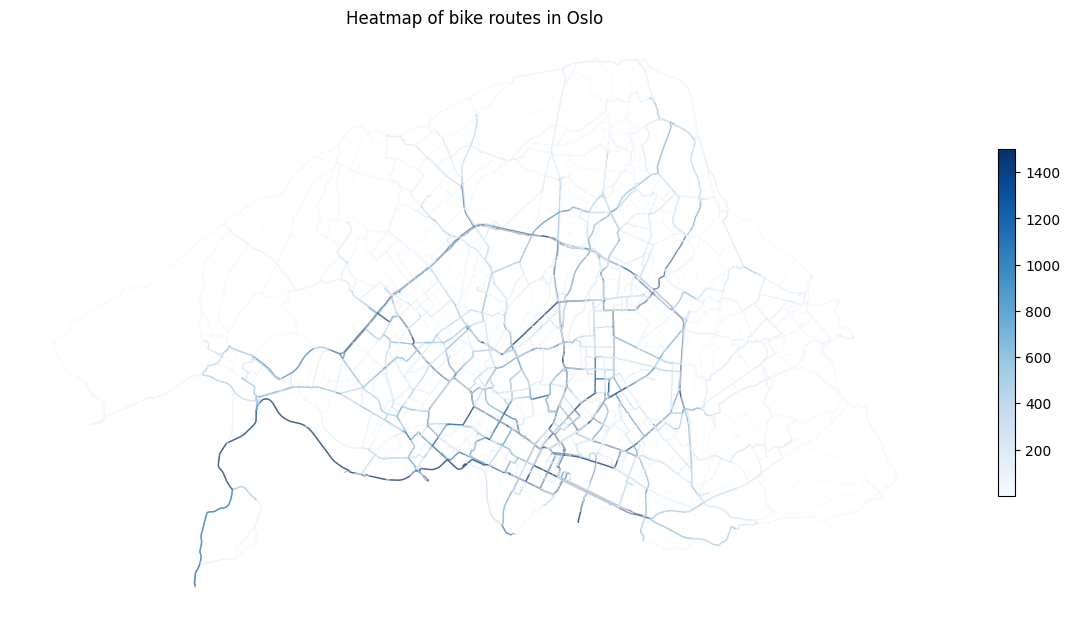

In [10]:
# Set the column to plot and the colormap
column_to_plot = 'count'
cmap = 'Blues'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,15))

# Create a Normalize object to map the data column's values to the colormap range
vmin = segments_gdf[column_to_plot].min()
# vmax = segments_gdf[column_to_plot].max()
vmax = 1500
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot the data
segments_gdf.plot(column=column_to_plot, cmap=cmap, linewidth=1, alpha=0.5, ax=ax, vmin=vmin, vmax=vmax)

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.3)

# Remove all axis spines and ticks
ax.axis('off')

# Set the title of the plot
ax.set_title(f'Heatmap of bike routes in Oslo')

# Show the plot
plt.show()

## Color by bikeroute or not

The waytypes_d column describes the waytype of the geometry for that route. 

Geometry for entry 0 in bike_data, is one linestring:


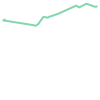

This linestring are divided into line-segments:
LINESTRING (10.773951 59.914912, 10.77397 59.914908, 10.774103 59.914886, 10.774068 59.914848, 10.773984 59.914862, 10.773708 59.914894, 10.773577 59.914939, 10.773415 59.914997, 10.77306 59.915129, 10.772964 59.915163, 10.772863 59.915199, 10.772746 59.91524, 10.772628 59.915284, 10.772004 59.915514, 10.771963 59.915487, 10.771914 59.915458, 10.770433 59.914728, 10.770328 59.914783, 10.769923 59.915031, 10.769877 59.915058, 10.769772 59.915094, 10.76965 59.915035, 10.769483 59.914961, 10.769473 59.914957, 10.769375 59.914913, 10.769289 59.914874, 10.769186 59.914828, 10.768864 59.914682, 10.768753 59.914633, 10.767702 59.914156, 10.767596 59.914107, 10.767529 59.914078, 10.767393 59.914019, 10.766811 59.913754, 10.766371 59.913551, 10.766257 59.9135, 10.766145 59.913447, 10.766055 59.913406, 10.765618 59.913236, 10.76542 59.913174, 10.765297 59.913134, 10.765179 59.913096, 10.764617 59.912903, 10.764094 59.912733, 10.763841 59.91263, 10.

In [11]:
print("Geometry for entry 0 in bike_data, is one linestring:")
display(bike_data['geometry'].iloc[0])

print("This linestring are divided into line-segments:")
print(bike_data['geometry'].iloc[0])
# count number of lines in a linestring
print("\nIn total it has {} segments\n".format(len(segments(bike_data['geometry'].iloc[0]))))

print("Waytypes_d has 3 integers;\n (from segment number) (to segment number) (is type XX); ...\n")
print("Eg. for entry 0 in waytypes_d, we have:\n {}".format(bike_data['waytypes_d'].iloc[0]))

In [12]:
segments_gdf['waytype'].unique()

array(['7', '2', '3', '6', '4', '1', '8', '0'], dtype=object)

Frequently used routes from bike rentals in Oslo


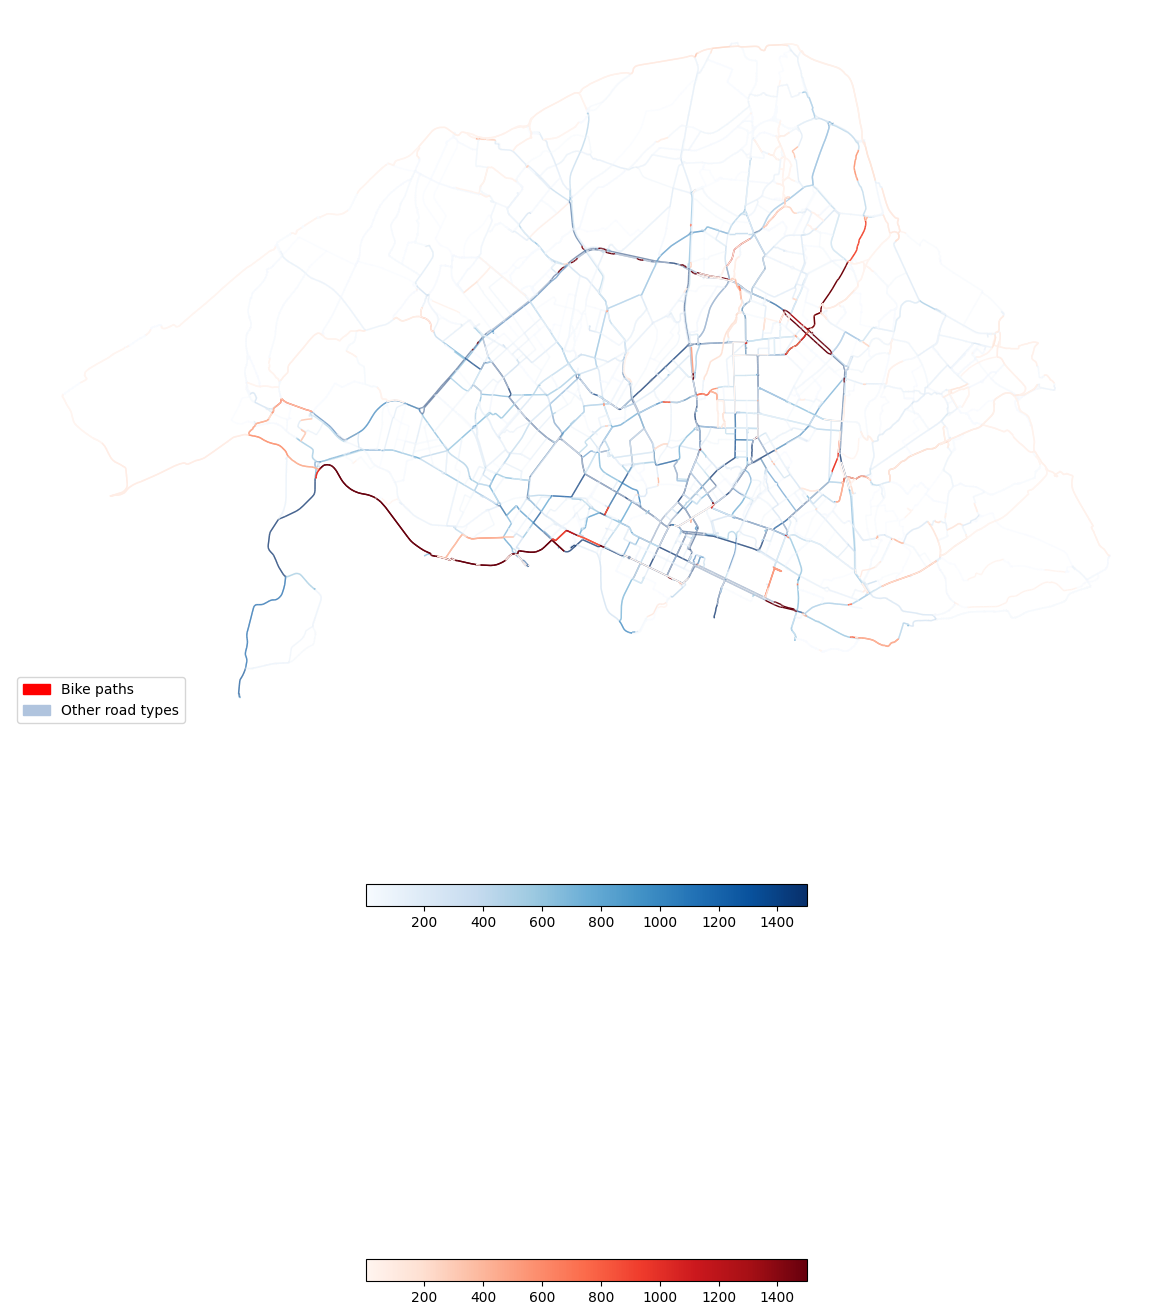

In [27]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches

# Set the column to plot
column_to_plot = 'count'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15))


# Create a Normalize object to map the data column's values to the colormap range
vmin = segments_gdf[column_to_plot].min()
# vmax = segments_gdf[column_to_plot].max()
vmax = 1500
norm = Normalize(vmin=vmin, vmax=vmax)



# Filter the GeoDataFrame based on the condition
segments_gdf_red = segments_gdf[segments_gdf['waytype'] == '6']
segments_gdf_blue = segments_gdf[segments_gdf['waytype'] != '6']

# Plot the data with different colormaps
segments_gdf_blue.plot(column=column_to_plot, cmap='Blues', linewidth=1, alpha=0.5, ax=ax, vmax=vmax)
segments_gdf_red.plot(column=column_to_plot, cmap='Reds', linewidth=1, alpha=1, ax=ax, vmax=vmax)

# Legend that describes the colors
red_patch = mpatches.Patch(color='red', label='Bike paths')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Other road types')
plt.legend(handles=[red_patch, blue_patch], loc='lower left')

# Create a color bar for each colormap
cbar_blue = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
cbar_red = plt.cm.ScalarMappable(cmap='Reds', norm=norm)

# Set the color bar ranges based on the data
cbar_red.set_array(segments_gdf_red[column_to_plot])
cbar_blue.set_array(segments_gdf_blue[column_to_plot])

# Add color bars to the plot
plt.colorbar(cbar_red, ax=ax, shrink=0.3, orientation='horizontal')
plt.colorbar(cbar_blue, ax=ax, shrink=0.3, orientation='horizontal')

# Remove all axis spines and ticks
ax.axis('off')

# Set the title of the plot
# ax.set_title('Frequently used routes from bike rentals in Oslo')
print('Frequently used routes from bike rentals in Oslo')

# Show the plot
plt.tight_layout()
plt.savefig('../heatmap_routes_frequently.png', bbox_inches='tight', dpi=600)
plt.show()


All routes from bike rentals in Oslo


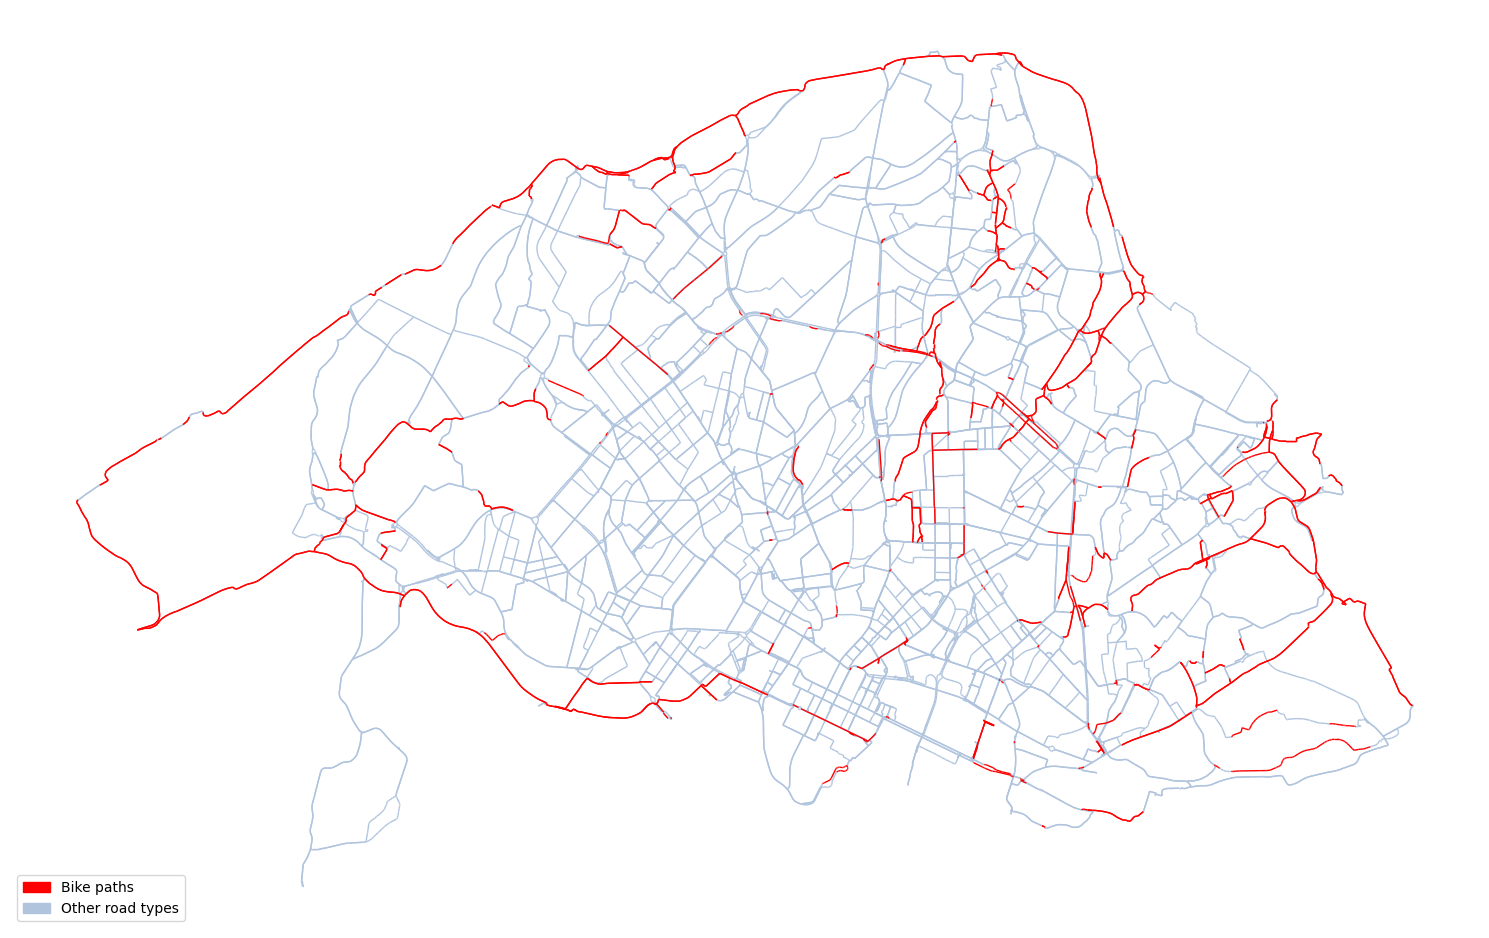

In [28]:
import matplotlib.pyplot as plt
import geopandas as gpd


# Set the column to plot
column_to_plot = 'count'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Filter the GeoDataFrame based on the condition
segments_gdf_red = segments_gdf[segments_gdf['waytype'] == '6']
segments_gdf_blue = segments_gdf[segments_gdf['waytype'] != '6']

# Plot the data with different colors
segments_gdf_blue.plot(column=column_to_plot, color='lightsteelblue', linewidth=1, alpha=1, ax=ax)
segments_gdf_red.plot(column=column_to_plot, color='red', linewidth=1, alpha=1, ax=ax)

# Legend that describes the colors
red_patch = mpatches.Patch(color='red', label='Bike paths')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Other road types')
plt.legend(handles=[red_patch, blue_patch], loc='lower left')

# Remove all axis spines and ticks
ax.axis('off')

# Set the title of the plot
# ax.set_title('All routes from bike rentals in Oslo')
print('All routes from bike rentals in Oslo')

# Show the plot
plt.tight_layout()
plt.savefig('../heatmap_routes_all.png', bbox_inches='tight', dpi=600)
plt.show()


Routes from bike rentals in Oslo - top 1000 segments


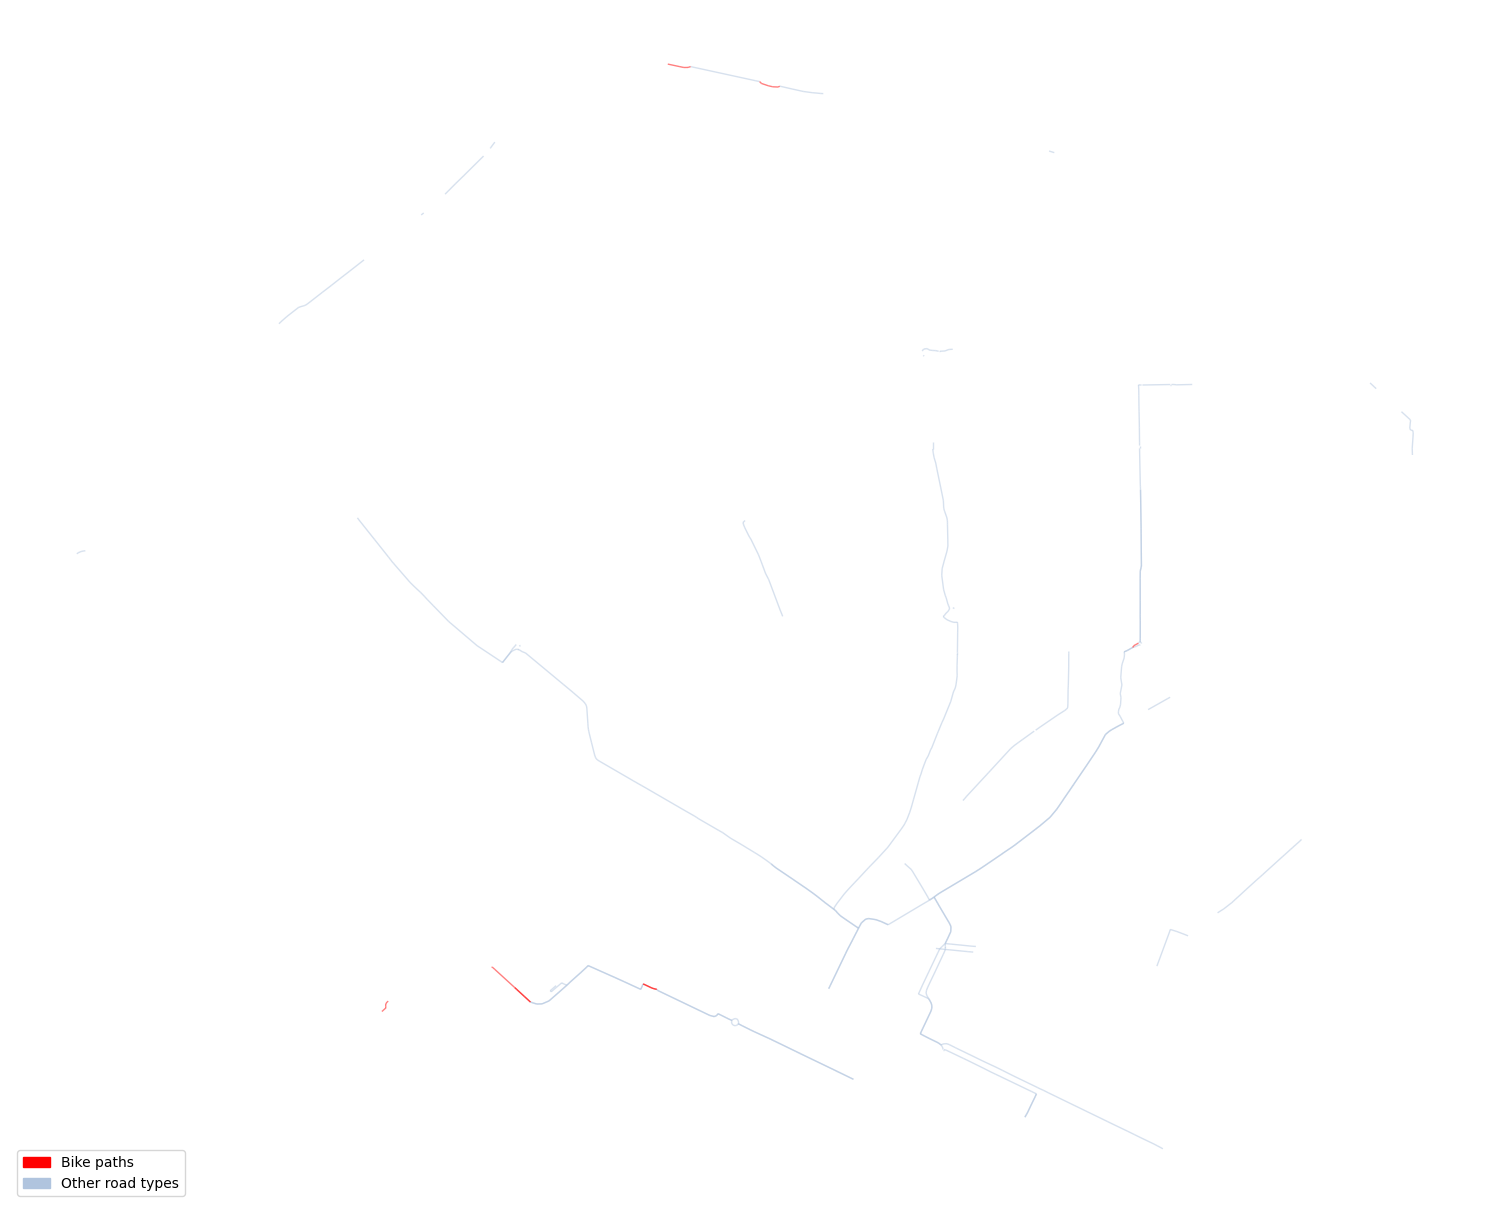

In [29]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches

# Keep only segments with the top 100 highest counts
segments_gdf_most_freq = segments_gdf.sort_values(by='count', ascending=False).iloc[:1000]

# segments_gdf_most_freq


# Set the column to plot
column_to_plot = 'count'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Filter the GeoDataFrame based on the condition
segments_gdf_red = segments_gdf_most_freq[segments_gdf_most_freq['waytype'] == '6']
segments_gdf_blue = segments_gdf_most_freq[segments_gdf_most_freq['waytype'] != '6']

# Plot the data with different colors
segments_gdf_blue.plot(column=column_to_plot, color='lightsteelblue', linewidth=1, alpha=0.5, ax=ax)
segments_gdf_red.plot(column=column_to_plot, color='red', linewidth=1, alpha=0.5, ax=ax)


# Legend that describes the colors
red_patch = mpatches.Patch(color='red', label='Bike paths')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Other road types')
plt.legend(handles=[red_patch, blue_patch], loc='lower left')

# Remove all axis spines and ticks
ax.axis('off')

# Set the title of the plot
# ax.set_title('Routes from bike rentals in Oslo - top 1000 segments')
print('Routes from bike rentals in Oslo - top 1000 segments')

# Show the plot
plt.tight_layout()
plt.savefig('../heatmap_routes_top1000.png', bbox_inches='tight', dpi=600)
plt.show()


## Dict for translating route types in to route names

In [17]:
waytype_dict = {
    '0': 'unkown', 
    '1': 'State Road', 
    '2': 'Road',
    '3': 'Street',
    '4': 'Path',
    '5': 'Track',
    '6': 'Cycleway',
    '7': 'Footway',
    '8': 'Steps',
    '9': 'Ferry',
    '10': 'Construction'
}

count_roads = pd.DataFrame(np.unique(segments_gdf.waytype, return_counts=True)).T

count_roads.columns = ['waytype', 'count']

# add column with waytype name
count_roads['waytype_name'] = count_roads['waytype'].map(waytype_dict)

count_roads

,waytype,count,waytype_name
0,0,16,unkown
1,1,2058,State Road
2,2,9188,Road
3,3,10761,Street
4,4,127,Path
5,6,6036,Cycleway
6,7,6299,Footway
7,8,25,Steps
